In [2]:
import os
import pickle
import pandas as pd

**Q1. Notebook**

In [23]:
PARENT_DIR = os.path.dirname(os.path.dirname(os.getcwd()))

with open(f'{PARENT_DIR}/models/model.bin', 'rb') as f_in:
    dv, model = pickle.load(f_in)

In [24]:
categorical = ['PULocationID', 'DOLocationID']

def read_data(url):
    df = pd.read_parquet(url)
    
    df['duration'] = df.tpep_dropoff_datetime - df.tpep_pickup_datetime
    df['duration'] = df.duration.dt.total_seconds() / 60

    df = df[(df.duration >= 1) & (df.duration <= 60)].copy()

    df[categorical] = df[categorical].fillna(-1).astype('int').astype('str')
    
    return df

In [31]:
url = 'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-03.parquet'
df = read_data(url)

dicts = df[categorical].to_dict(orient='records')
X_val = dv.transform(dicts)
y_pred = model.predict(X_val)

print(f'Standard deviation: {y_pred.std():.4f}')

Standard deviation: 6.2475


**Q2. Preparing the output**

In [32]:
year = 2023
month = 3

df['ride_id'] = f'{year:04d}/{month:02d}_' + df.index.astype('str')

df_result = pd.DataFrame()
df_result['ride_id'] = df['ride_id']
df_result['prediction'] = y_pred

In [34]:
output_file = 'results.parquet'

df_result.to_parquet(
    output_file,
    engine='pyarrow',
    compression=None,
    index=False
)

In [39]:
file_size_bytes = os.path.getsize(output_file)
file_size_mb = file_size_bytes / (1024 * 1024)

print(f"File size: {file_size_mb:.1f} MB")

File size: 65.5 MB


**Q3. Creating the scoring script**

jupyter nbconvert --to script notebook_name.ipynb

**Q4. Virtual environment**

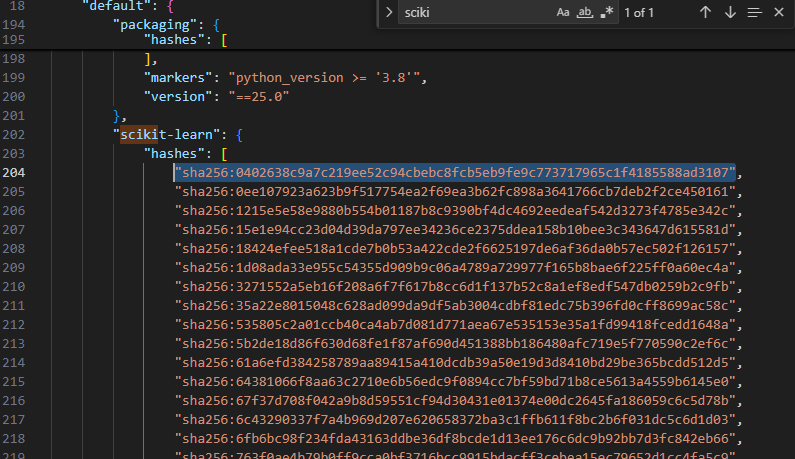

**Q5. Parametrize the script**

In [46]:
!jupyter nbconvert scoring.ipynb --to python --output scoring.py

[NbConvertApp] Converting notebook scoring.ipynb to python
[NbConvertApp] Writing 1036 bytes to scoring.py


In [50]:
!python scoring.py --year 2023 --month 4 --dataset "yellow"

Dataset for 2023-04 downloaded successfully!
Dimensions: df.shape=(3199715, 20)
Generating predictions...
Mean predicted duration of 2023-04: 14.2923


**Q6. Docker container**

docker build -t mlops-homework-week-4:v1 .

docker run --rm mlops-homework-week-4:v1 --year 2023 --month 3

In [53]:
!docker build -t mlops-homework-week-4:v1 .

#0 building with "desktop-linux" instance using docker driver

#1 [internal] load build definition from Dockerfile
#1 DONE 0.0s

#1 [internal] load build definition from Dockerfile
#1 transferring dockerfile: 236B done
#1 DONE 0.0s

#2 [internal] load metadata for docker.io/agrigorev/zoomcamp-model:mlops-2024-3.10.13-slim
#2 DONE 0.6s

#3 [internal] load .dockerignore
#3 transferring context: 2B done
#3 DONE 0.0s

#4 [1/4] FROM docker.io/agrigorev/zoomcamp-model:mlops-2024-3.10.13-slim@sha256:f54535b73a8c3ef91967d5588de57d4e251b22addcbbfb6e71304a91c1c7027f
#4 resolve docker.io/agrigorev/zoomcamp-model:mlops-2024-3.10.13-slim@sha256:f54535b73a8c3ef91967d5588de57d4e251b22addcbbfb6e71304a91c1c7027f 0.0s done
#4 DONE 0.0s

#5 [internal] load build context
#5 transferring context: 1.76kB done
#5 DONE 0.0s

#6 [2/4] WORKDIR /app
#6 CACHED

#7 [3/4] COPY scoring_docker.py .
#7 DONE 0.0s

#8 [4/4] RUN pip install pandas pyarrow scikit-learn==1.5.0
#8 1.488 Collecting pandas
#8 1.631   Download

In [54]:
!docker run --rm mlops-homework-week-4:v1 --year 2023 --month 3

Dataset for 2023-03 downloaded successfully!
Dimensions: df.shape=(3316216, 20)
Generating predictions...
Mean predicted duration of 2023-03: 0.19
